In [1]:
library('pROC')
library('IRdisplay')
library('lme4')
library('Hmisc')
library('MLmetrics')
library('ggExtra')

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Loading required package: Matrix

Loading required package: lattice

Loading required package: survival

Loading required package: Formula

Loading required package: ggplot2


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:base’:

    format.pval, units



Attaching package: ‘MLmetrics’


The following object is masked from ‘package:base’:

    Recall




In [ ]:
# run after Error Prediction Model - Data Preparation, where wordLevelChanges.csv is built
# Note that this notebook is in R, whereas data preparation was in Python

### New code: join the Aggregate probabilities and the WordLevelChanges here from each of their CSVs.

In [2]:
wdfs = read.csv('output/wordLevelChanges.csv', stringsAsFactors=F)
wdfs$change = sapply(wdfs$code, function(x){
    if (x == 'M'){
        return(0)
    } else { 
        return(1)
    }
})
wdfs$one =1

In [3]:
names(wdfs)

[1] "bnc_unigram_index"                                  
  [2] "bnc_unigram_prob"                                   
  [3] "bnc_unigram_word"                                   
  [4] "bnc_trigram_index"                                  
  [5] "bnc_trigram_prob"                                   
  [6] "bnc_trigram_word"                                   
  [7] "roark_scores_prefix"                                
  [8] "roark_scores_word"                                  
  [9] "roark_scores_prefix.1"                              
 [10] "roark_scores_srprsl"                                
 [11] "roark_scores_SynSp"                                 
 [12] "roark_scores_LexSp"                                 
 [13] "roark_scores_ambig"                                 
 [14] "roark_scores_open"                                  
 [15] "roark_scores_rernk"                                 
 [16] "roark_scores_toprr"                                 
 [17] "roark_scores_stps"                                  
 [18] "big_lm_scores_Unnamed..0"                           
 [19] "big_lm_scores_prob"                                 
 [20] "big_lm_scores_word"                                 
 [21] "kenlm_scores_prob"                                  
 [22] "kenlm_scores_preceding"                             
 [23] "kenlm_scores_unk"                                   
 [24] "kenlm_scores_word"                                  
 [25] "gpt2_normal_scores_prob"                            
 [26] "gpt2_normal_scores_word"                            
 [27] "gpt2_medium_scores_prob"                            
 [28] "gpt2_medium_scores_word"                            
 [29] "bert_scores_prob"                                   
 [30] "bert_scores_word"                                   
 [31] "bart_scores_prob"                                   
 [32] "bart_scores_word"                                   
 [33] "sCounter"                                           
 [34] "sentence_index"                                     
 [35] "word"                                               
 [36] "code"                                               
 [37] "input_subject"                                      
 [38] "output_subject"                                     
 [39] "conc_bigram"                                        
 [40] "conc_conc_m"                                        
 [41] "conc_conc_sd"                                       
 [42] "conc_unknown"                                       
 [43] "conc_total"                                         
 [44] "conc_percent_known"                                 
 [45] "conc_subtlex"                                       
 [46] "conc_dom_pos"                                       
 [47] "kpm_alternative_spelling"                           
 [48] "kpm_freq_pm"                                        
 [49] "kpm_dom_pos_subtlex"                                
 [50] "kpm_nletters"                                       
 [51] "kpm_nphon"                                          
 [52] "kpm_nsyll"                                          
 [53] "kpm_lemma_highest_pos"                              
 [54] "kpm_aoa_kup"                                        
 [55] "kpm_perc_known"                                     
 [56] "kpm_aoa_kup_lem"                                    
 [57] "kpm_perc_known_lem"                                 
 [58] "kpm_aoa_bird_lem"                                   
 [59] "kpm_aoa_bristol_lem"                                
 [60] "kpm_aoa_cort_lem"                                   
 [61] "kpm_aoa_schock"                                     
 [62] "pic_ipa"                                            
 [63] "pic_ipa_ss_array"                                   
 [64] "pic_ipa_ss"                                         
 [65] "pic_ipa_n"                                          
 [66] "pic_ortho"                                          
 [67] "pic_ortho_ss_array"                

In [4]:
# convert log probabilities to surprisals
wdfs$bnc_unigram_prob = -1 * wdfs$bnc_unigram_prob
wdfs$bnc_trigram_prob = -1 * wdfs$bnc_trigram_prob
wdfs$kenlm_scores_prob = -1 * wdfs$kenlm_scores_prob
wdfs$big_lm_scores_prob = -1 * wdfs$big_lm_scores_prob
wdfs$gpt2_normal_scores_prob = -1 * wdfs$gpt2_normal_scores_prob
wdfs$gpt2_medium_scores_prob = -1 * wdfs$gpt2_medium_scores_prob
wdfs$bert_scores_prob = -1 * wdfs$bert_scores_prob
wdfs$bart_scores_prob = -1 * wdfs$bart_scores_prob

In [5]:
wdfs[1,c('bnc_unigram_prob','bnc_trigram_prob','kenlm_scores_prob','big_lm_scores_prob',
        'gpt2_normal_scores_prob', 'gpt2_medium_scores_prob', 'bert_scores_prob', 'bart_scores_prob')]

,bnc_unigram_prob,bnc_trigram_prob,kenlm_scores_prob,big_lm_scores_prob,gpt2_normal_scores_prob,gpt2_medium_scores_prob,bert_scores_prob,bart_scores_prob
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,3.310068,2.994068,3.516777,3.202744,3.570354,3.225354,0.3260236,1.289798


In [6]:
dim(wdfs)

[1] 27290   199

[ ] part of speech  
[X] number of syllables: kpm_nsyll  
[X] word length: kpm_nphon  
[X] aoa_rating: kpm_aoa_kup  
[X] concreteness: conc_conc_m  
[X] phonological neighborhood density: pld20  
[X] contextual diversity: Need Subtlexus: SUBTLCD  

random effects structure
https://www4.stat.ncsu.edu/~reich/ABA/code/DICmixed

In [7]:
wdfs

bnc_unigram_index,bnc_unigram_prob,bnc_unigram_word,bnc_trigram_index,bnc_trigram_prob,bnc_trigram_word,roark_scores_prefix,roark_scores_word,roark_scores_prefix.1,roark_scores_srprsl,⋯,initial_gpt2_medium_probability_quartile,initial_bert_probability,initial_bert_probability_rank,initial_bert_probability_quartile,initial_bart_probability,initial_bart_probability_rank,initial_bart_probability_quartile,thread_id,change,one
<int>,<dbl>,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<dbl>,<dbl>
0,3.310068,each,0,2.994068,each,pfix:1,each,6.566,2.851578,⋯,1,-13.29464,0,0,-16.23387,13,1,0_0,0,1
1,7.309903,nonfiction,1,8.412464,nonfiction,pfix:2,nonfiction,18.290,5.091669,⋯,1,-13.29464,0,0,-16.23387,13,1,0_0,1,1
2,3.631093,book,2,3.756868,book,pfix:3,book,28.519,4.442398,⋯,1,-13.29464,0,0,-16.23387,13,1,0_0,0,1
3,2.600407,has,3,2.253614,has,pfix:4,has,32.402,1.686800,⋯,1,-13.29464,0,0,-16.23387,13,1,0_0,0,1
4,1.681165,a,4,1.317157,a,pfix:5,a,35.256,1.239042,⋯,1,-13.29464,0,0,-16.23387,13,1,0_0,0,1
5,3.737589,call,5,3.763689,call,pfix:6,call,44.218,3.892147,⋯,1,-13.29464,0,0,-16.23387,13,1,0_0,0,1
6,3.321531,number,6,3.708286,number,pfix:7,number,53.366,3.972926,⋯,1,-13.29464,0,0,-16.23387,13,1,0_0,0,1
7,2.162270,on,7,2.029635,on,pfix:8,on,58.319,2.151495,⋯,1,-13.29464,0,0,-16.23387,13,1,0_0,1,1
8,2.804867,its,8,2.394903,its,pfix:9,its,62.220,1.693748,⋯,1,-13.29464,0,0,-16.23387,13,1,0_0,0,1


In [8]:
# interpolate missing values in the input
fixed_effects = c('one','word','bnc_unigram_prob', 'bnc_trigram_prob', 'roark_scores_SynSp', 
'roark_scores_LexSp', 'big_lm_scores_prob', 'kenlm_scores_prob','sCounter', 
'kpm_aoa_kup','kpm_nphon', 'kpm_nsyll','conc_conc_m','pld20', 'SUBTLCD', 
'normalized_biglm_probability', 'normalized_WSJ_Roark_Negative.Log.Probability',
'normalized_BNC_KNN_unigramProb', 'normalized_BNC_KNN_trigramProb',
'normalized_kenlm_probability', 'normalized_bllip_probability', 
'normalized_bllip_wsj_probability', 'normalized_mikolov_wsj_probability','pic_ipa_ss','kenlm_scores_prob',
                 'normalized_gpt2_normal_probability', 'normalized_gpt2_medium_probability', 'normalized_bert_probability',
                 'normalized_bart_probability',
                 'bert_scores_prob', 'gpt2_normal_scores_prob', 'gpt2_medium_scores_prob', 'bart_scores_prob')

for(fixed_effect in fixed_effects){
    print(paste(fixed_effect, 'missing', length(which(is.na(wdfs[,fixed_effect]))), 'observations'))
  wdfs[is.na(wdfs[,fixed_effect]), fixed_effect] <- mean(wdfs[,fixed_effect], na.rm = TRUE)
}

[1] "one missing 0 observations"
[1] "word missing 0 observations"


Warning message in mean.default(wdfs[, fixed_effect], na.rm = TRUE):
“argument is not numeric or logical: returning NA”


[1] "bnc_unigram_prob missing 0 observations"
[1] "bnc_trigram_prob missing 0 observations"
[1] "roark_scores_SynSp missing 0 observations"
[1] "roark_scores_LexSp missing 0 observations"
[1] "big_lm_scores_prob missing 0 observations"
[1] "kenlm_scores_prob missing 0 observations"
[1] "sCounter missing 0 observations"
[1] "kpm_aoa_kup missing 5562 observations"
[1] "kpm_nphon missing 435 observations"
[1] "kpm_nsyll missing 435 observations"
[1] "conc_conc_m missing 2457 observations"
[1] "pld20 missing 253 observations"
[1] "SUBTLCD missing 45 observations"
[1] "normalized_biglm_probability missing 0 observations"
[1] "normalized_WSJ_Roark_Negative.Log.Probability missing 0 observations"
[1] "normalized_BNC_KNN_unigramProb missing 0 observations"
[1] "normalized_BNC_KNN_trigramProb missing 0 observations"
[1] "normalized_kenlm_probability missing 0 observations"
[1] "normalized_bllip_probability missing 0 observations"
[1] "normalized_bllip_wsj_probability missing 0 observations"
[1]

# Fixed Effects Logistic Regression

In [9]:
fixed_effects

[1] "one"                                          
 [2] "word"                                         
 [3] "bnc_unigram_prob"                             
 [4] "bnc_trigram_prob"                             
 [5] "roark_scores_SynSp"                           
 [6] "roark_scores_LexSp"                           
 [7] "big_lm_scores_prob"                           
 [8] "kenlm_scores_prob"                            
 [9] "sCounter"                                     
[10] "kpm_aoa_kup"                                  
[11] "kpm_nphon"                                    
[12] "kpm_nsyll"                                    
[13] "conc_conc_m"                                  
[14] "pld20"                                        
[15] "SUBTLCD"                                      
[16] "normalized_biglm_probability"                 
[17] "normalized_WSJ_Roark_Negative.Log.Probability"
[18] "normalized_BNC_KNN_unigramProb"               
[19] "normalized_BNC_KNN_trigramProb"               
[20] "normalized_kenlm_probability"                 
[21] "normalized_bllip_probability"                 
[22] "normalized_bllip_wsj_probability"             
[23] "normalized_mikolov_wsj_probability"           
[24] "pic_ipa_ss"                                   
[25] "kenlm_scores_prob"                            
[26] "normalized_gpt2_normal_probability"           
[27] "normalized_gpt2_medium_probability"           
[28] "normalized_bert_probability"                  
[29] "normalized_bart_probability"                  
[30] "bert_scores_prob"                             
[31] "gpt2_normal_scores_prob"                      
[32] "gpt2_medium_scores_prob"                      
[33] "bart_scores_prob"

In [10]:
# basic fixed effects logistic regression

wdf = wdfs[,fixed_effects]
wdf$changed = as.numeric(wdfs$code != 'M')
model <- glm(changed ~ bnc_unigram_prob + bnc_trigram_prob + roark_scores_LexSp +  roark_scores_SynSp
+ big_lm_scores_prob + bert_scores_prob + gpt2_normal_scores_prob + gpt2_medium_scores_prob
             + bart_scores_prob
             + sCounter + kpm_aoa_kup + kpm_nphon + kpm_nsyll + conc_conc_m
, family=binomial(link='logit'),data=wdf)

In [11]:
summary(model)


Call:
glm(formula = changed ~ bnc_unigram_prob + bnc_trigram_prob + 
    roark_scores_LexSp + roark_scores_SynSp + big_lm_scores_prob + 
    bert_scores_prob + gpt2_normal_scores_prob + gpt2_medium_scores_prob + 
    bart_scores_prob + sCounter + kpm_aoa_kup + kpm_nphon + kpm_nsyll + 
    conc_conc_m, family = binomial(link = "logit"), data = wdf)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8597  -0.6278  -0.5202  -0.4274   2.4919  

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -2.424535   0.085632 -28.313  < 2e-16 ***
bnc_unigram_prob         0.004476   0.033866   0.132   0.8948    
bnc_trigram_prob         0.157931   0.022202   7.113 1.13e-12 ***
roark_scores_LexSp      -0.041612   0.019117  -2.177   0.0295 *  
roark_scores_SynSp       0.117520   0.026241   4.478 7.52e-06 ***
big_lm_scores_prob       0.115595   0.019691   5.870 4.35e-09 ***
bert_scores_prob         0.140056   0.016492   8.492  < 2e

Setting levels: control = 0, case = 1

Setting direction: controls < cases



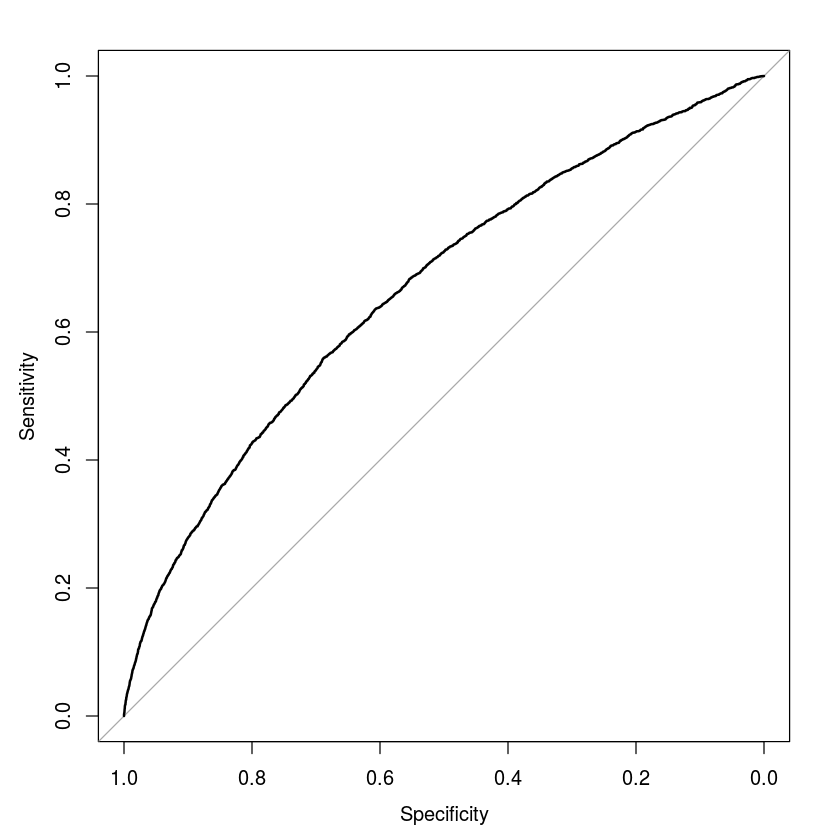

In [12]:
wdfs$predicted = predict(model, wdf, type='response')
df = data.frame(prob=wdfs$predicted, change=wdfs$change)
g <- roc(change ~prob, data = df)
plot(g)    

In [13]:
auc(g)

Area under the curve: 0.6664

In [14]:
colorizeVector = function(vector){
    colorramp = colorRampPalette(c("green", "red"))(n = 101)
    quantiles = quantile(vector, probs=seq(0,1,.01), na.rm=T)
    percentile_limits = sapply(vector, function(x){
        which.max(x <= quantiles)	
    })
    percentile = sapply(percentile_limits, function(x){ifelse(length(x) > 0, x, NA)})
    colors = colorramp[percentile]
    return(colors)
}
wdfs$color = colorizeVector(wdfs$predicted)

colorizeSentence = function(df, sentenceIndex, format = 'HTML'){
    sentence = subset(df, sentence_index == sentenceIndex)
    sentence = sentence[order(sentence$bnc_unigram_index),]
    if (format =='HTML'){
        html_pieces = paste0('<font color="',sentence$color,'">',sentence$word, '</font>')    
        return(paste(html_pieces, collapse =' '))
    } else if (format == 'latex'){
        latex_pieces = paste0('{color[HTML]{',gsub('#','',sentence$color),'}',sentence$word,'}')
        #{\color[HTML]{color}text}
        return(paste(latex_pieces, collapse =' '))
    }
}

colorizeSentence(wdfs,1661,'latex')
display_html(colorizeSentence(wdfs,1661))

[1] "{color[HTML]{44BA00}you} {color[HTML]{0CF200}can} {color[HTML]{1EE000}see} {color[HTML]{5BA300}that} {color[HTML]{B54900}they} {color[HTML]{42BC00}have} {color[HTML]{ED1100}time} {color[HTML]{609E00}to} {color[HTML]{C43A00}run}"

you can see that they have time to run

# Mixed Effects Logistic Regression Model

In [15]:
print(names(wdf))
print(nrow(wdf))

 [1] "one"                                          
 [2] "word"                                         
 [3] "bnc_unigram_prob"                             
 [4] "bnc_trigram_prob"                             
 [5] "roark_scores_SynSp"                           
 [6] "roark_scores_LexSp"                           
 [7] "big_lm_scores_prob"                           
 [8] "kenlm_scores_prob"                            
 [9] "sCounter"                                     
[10] "kpm_aoa_kup"                                  
[11] "kpm_nphon"                                    
[12] "kpm_nsyll"                                    
[13] "conc_conc_m"                                  
[14] "pld20"                                        
[15] "SUBTLCD"                                      
[16] "normalized_biglm_probability"                 
[17] "normalized_WSJ_Roark_Negative.Log.Probability"
[18] "normalized_BNC_KNN_unigramProb"               
[19] "normalized_BNC_KNN_trigramProb"         

In [16]:
# add residuals 
wdf$resid_bnc_trigram_prob = lm(bnc_trigram_prob ~ bnc_unigram_prob, data=wdf)$residuals

# Note to self: p. 33 of the paper.
for (structuredModel in c('roark_scores_SynSp','big_lm_scores_prob','kenlm_scores_prob',
                          'gpt2_normal_scores_prob', 'gpt2_medium_scores_prob', 'bert_scores_prob',
                         'bart_scores_prob')){
    wdf[[paste0('resid_',structuredModel)]] = lm(as.formula(paste0(structuredModel, 
        ' ~ bnc_trigram_prob + bnc_unigram_prob')), data=wdf)$residuals
}

In [17]:
wdf$subject_id = as.factor(wdfs$user)
wdf$upstream_subject_id = as.factor(wdfs$upstream_subject_id)

mixed_model <- glmer(changed ~ bnc_unigram_prob + resid_bnc_trigram_prob + resid_roark_scores_SynSp 
+ resid_big_lm_scores_prob + resid_kenlm_scores_prob
                     + resid_gpt2_normal_scores_prob + resid_gpt2_medium_scores_prob + resid_bert_scores_prob
                     + resid_bart_scores_prob
                     + sCounter + kpm_aoa_kup + kpm_nphon + kpm_nsyll + conc_conc_m + pld20 
+ (1|subject_id) + (1|upstream_subject_id)
,family=binomial(link='logit'),data=wdf, control=glmerControl(optimizer="bobyqa",
                            optCtrl=list(maxfun=2e5)))

In [18]:
# This is Table 4

summary(mixed_model)


Correlation matrix not shown by default, as p = 16 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
changed ~ bnc_unigram_prob + resid_bnc_trigram_prob + resid_roark_scores_SynSp +  
    resid_big_lm_scores_prob + resid_kenlm_scores_prob + resid_gpt2_normal_scores_prob +  
    resid_gpt2_medium_scores_prob + resid_bert_scores_prob +  
    resid_bart_scores_prob + sCounter + kpm_aoa_kup + kpm_nphon +  
    kpm_nsyll + conc_conc_m + pld20 + (1 | subject_id) + (1 |  
    upstream_subject_id)
   Data: wdf
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e+05))

     AIC      BIC   logLik deviance df.resid 
 23707.0  23854.8 -11835.5  23671.0    27272 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.2342 -0.4664 -0.3669 -0.2796  4.8887 

Random effects:
 Groups              Name        Variance Std.Dev.
 subject_id          (Intercept) 0.06709  0.2590  
 upstream_subject_id (Intercept) 0.13775  0.3712  
Number of obs: 2729

In [19]:
wdfs$me_predicted = predict(mixed_model, wdf, type='response')
initial_sentences = subset(wdfs, upstream_pointer ==-1 & global_chain ==0)

colHTMLStore = mat.or.vec(20,1)
for (sid in c(0:39)){
    target_index = unique(subset(initial_sentences, stimulus_id == sid)$sentence_index)
    
    if (sid <= 20){
         colHTMLStore[sid] = colorizeSentence(wdfs, target_index, format='latex')   
    }
    colorHTML = colorizeSentence(wdfs,target_index)
    display_html(colorHTML)
}

write(paste0(colHTMLStore, collapse='\n \\\\ \n'), file = "figures/logisticRegression.txt")

each nonfiction book has a call number on its spine

some acids you may know are vinegar and lemon juice

the fly is next to the food bowl

did you not notice the label beside the soup

the county may have several cities or towns in it

the third and the fourth were around me

he was still wearing the opera mask

she went on a short hike in the afternoon

sandra crossed the court because the sun was in her eyes

now i want her to carry me to bed

he found the strange thing to be

they can read the label and use the medicine safely

a dietitian goes to college for at least 4 years

a fly buzzed over the oilcloth on the kitchen table

you may not notice yourself growing from day to day

we have two different systems for you

you cannot double dip them between hot and cold

we live in a trap and that is all well

the last prisoner was murdered last night

his experience makes him the one thing that time

then she would walk slowly into the tube farm

to see what they have done to her already

i keep on breaking up to the shooting

research has changed in the marketplace some services

the other thing was for one thousand dollars per hour

how do you know the difference between hot and cold

a single speed is an iron rod that wraps

one can send messages a draft in the village

he was a strong soul and had big arms

the dietitian goes to college for at least four years

it dropped right on the kitchen floor with beans

we can read the label and use the new sink

then the men closed the door behind them and bolted

i am sorry to be informed the text matters are elsewhere

models of atoms are much larger than the real thing

all experiments must be tested one fact at a time

Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.formula(formula = change ~ prob, data = df)

Data: prob in 22482 controls (change 0) < 4808 cases (change 1).
Area under the curve: 0.7095


Area under the curve: 0.7095

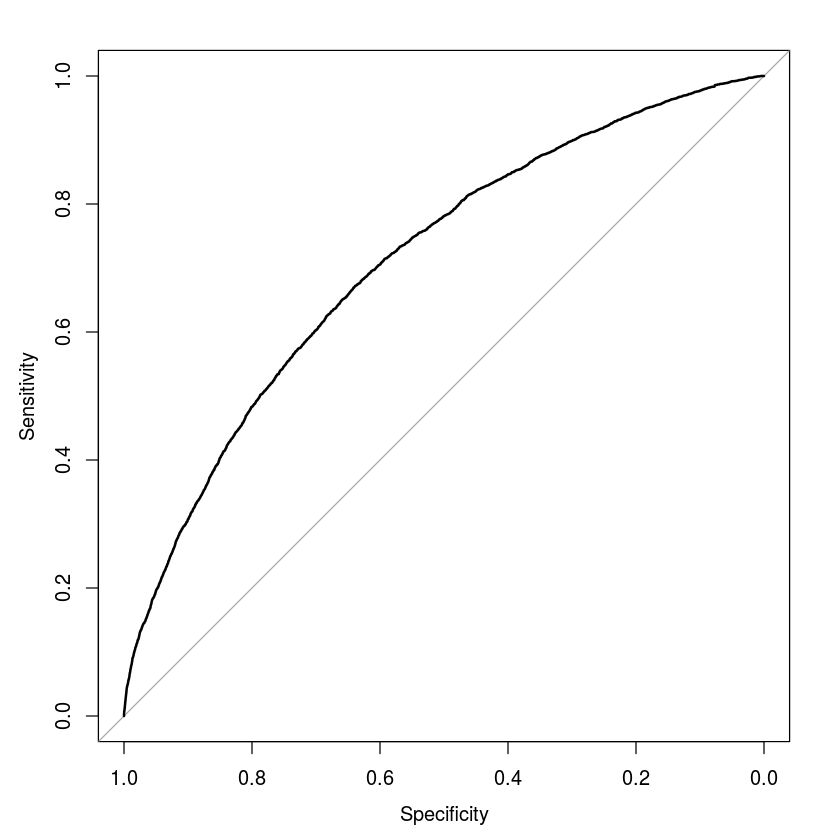

In [20]:
wdfs$me_predicted = predict(mixed_model, wdf, type='response')
df = data.frame(prob=wdfs$me_predicted, change=wdfs$change)
g <- roc(change ~prob, data = df)
print(plot(g))
auc(g)

In [21]:
mixed_model_nolms <- glmer(changed ~ sCounter + kpm_aoa_kup + kpm_nphon + kpm_nsyll + conc_conc_m + pld20 
+ (1|subject_id) + (1|upstream_subject_id)
,family=binomial(link='logit'),data=wdf, control=glmerControl(optimizer="bobyqa",
                            optCtrl=list(maxfun=2e5)))

Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.formula(formula = change ~ prob, data = df)

Data: prob in 22482 controls (change 0) < 4808 cases (change 1).
Area under the curve: 0.6513


Area under the curve: 0.6513

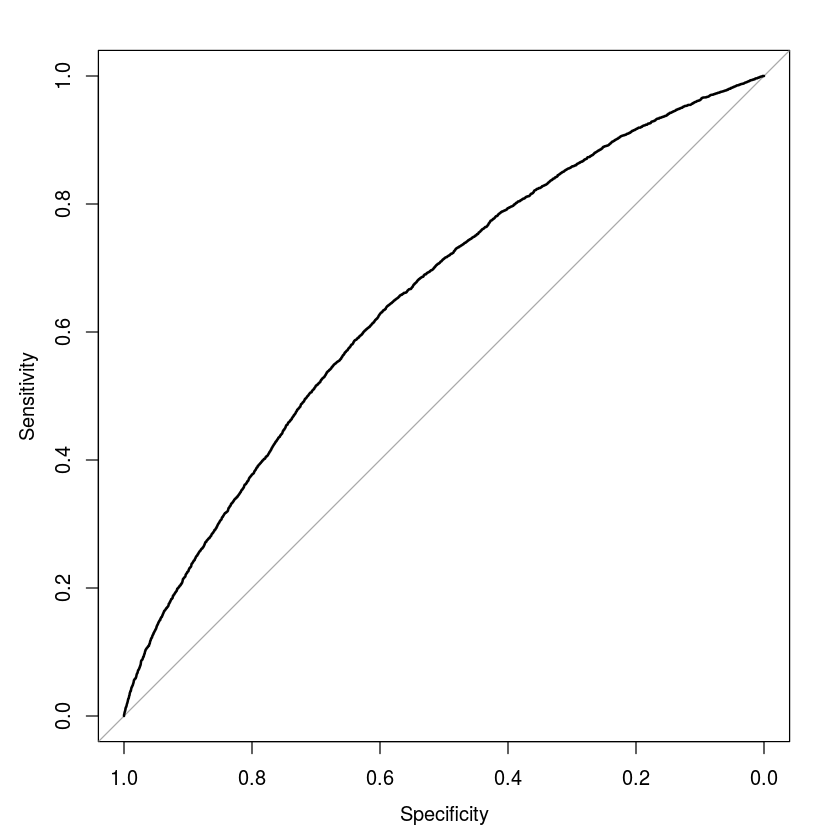

In [22]:
wdfs$nolms_predicted = predict(mixed_model_nolms, wdf, type='response')
df = data.frame(prob=wdfs$nolms_predicted, change=wdfs$change)
g <- roc(change ~prob, data = df)
print(plot(g))
auc(g)

In [23]:
# output the graph
source('telephone_analysis.R')

replacements = list()
replacements[['bnc_unigram_prob']] = 'BNC unigram surprisal'
replacements[['resid_bnc_trigram_prob']] = 'Residualized BNC trigram surprisal'
replacements[['resid_roark_scores_SynSp']] = 'Residualized Roark PCFG syntactic surprisal'
replacements[['resid_big_lm_scores_prob']] = 'Residualized Big LM surprisal'
replacements[['resid_kenlm_scores_prob']] = 'Residualized DS 5-gram surprisal'
replacements[['resid_gpt2_normal_scores_prob']] = 'Residualized GPT-2 surprisal'
replacements[['resid_gpt2_medium_scores_prob']] = 'Residualized GPT-2 medium surprisal'
replacements[['resid_bert_scores_prob']] = 'Residualized BERT surprisal'
replacements[['resid_bart_scores_prob']] = 'Residualized BART surprisal'
replacements[['sCounter']] = 'Position in sentence'
replacements[['kpm_aoa_kup']] = 'Age of acquisition'
replacements[['kpm_nphon']] = 'Number of phonemes'
replacements[['kpm_nsyll']] = 'Number of syllables'
replacements[['conc_conc_m']] = 'Concreteness'
replacements[['pld20']] = 'Phonological Neighborhood Density (PLD20)'
replacements[['upstream_subject_id']] = 'Speaker ID'
replacements[['subject_id']] = 'Listener ID'

modelName = "wordLevel"
wordLevelCaption = 'Mixed-effects logistic regression predicting whether a word will be transmitted successfully on the basis of its surprisal under various language models as well as other word properties. Significance of fixed-effects is computed following \\citet{satterthwaite1946}.'
wordLevelLabel = 'tab:wordlevel_lm'

modelToTable('mixed_logistic', modelName, mixed_model, replacements=replacements,file=paste0('LMs/',modelName,'_lm.tex'), 
        printVars = T, caption = wordLevelCaption, label = wordLevelLabel, where= 't')



Attaching package: ‘lmerTest’


The following object is masked from ‘package:lme4’:

    lmer


The following object is masked from ‘package:stats’:

    step




 [1] "(Intercept)"                                
 [2] "BNC unigram surprisal"                      
 [3] "Residualized BNC trigram surprisal"         
 [4] "Residualized Roark PCFG syntactic surprisal"
 [5] "Residualized Big LM surprisal"              
 [6] "Residualized DS 5-gram surprisal"           
 [7] "Residualized GPT-2 surprisal"               
 [8] "Residualized GPT-2 medium surprisal"        
 [9] "Residualized BERT surprisal"                
[10] "Residualized BART surprisal"                
[11] "Position in sentence"                       
[12] "Age of acquisition"                         
[13] "Number of phonemes"                         
[14] "Number of syllables"                        
[15] "Concreteness"                               
[16] "Phonological Neighborhood Density (PLD20)"  
$names
[1] "subject_id"          "upstream_subject_id"

$sc
[1] 1

$useSc
[1] FALSE

$class
[1] "VarCorr.merMod"

[1] "Alisases for random variables"
[1] "Listener ID" "Speaker ID" 


Cross-validation 

In [ ]:
# propotion matches per user

In [24]:
(wdfs$code)

[1] "M" "D" "M" "M" "M" "M" "M" "S" "M" "M" "M" "D" "D" "M" "S" "M" "M" "M"
   [19] "S" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "D" "M" "M" "M"
   [37] "M" "M" "M" "M" "M" "M" "D" "D" "M" "M" "M" "M" "M" "M" "M" "M" "M" "D"
   [55] "M" "M" "D" "D" "D" "M" "M" "M" "M" "D" "D" "M" "M" "S" "M" "M" "M" "M"
   [73] "M" "D" "M" "M" "M" "M" "M" "M" "M" "M" "D" "D" "M" "M" "M" "S" "M" "M"
   [91] "M" "M" "M" "M" "M" "M" "M" "S" "M" "M" "D" "D" "M" "D" "D" "D" "D" "D"
  [109] "D" "M" "D" "D" "M" "M" "M" "S" "M" "M" "M" "M" "M" "S" "M" "M" "M" "M"
  [127] "M" "D" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
  [145] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
  [163] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "S" "M" "M" "M" "M" "M" "M" "M"
  [181] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "S" "M" "M" "M" "M" "M" "M"
  [199] "M" "M" "M" "M" "D" "D" "D" "D" "M" "M" "M" "M" "S" "M" "D" "D" "D" "M"
  [217] "M" "M" "M" "M" "M" "M" "M" "M" "D" "D" "D" "D" "D" "D" "M" "M" "M" "M"
  [235] "M" "M" "M" "M" "M" "M" "M" "S" "M" "D" "D" "M" "M" "M" "M" "M" "M" "M"
  [253] "M" "S" "M" "M" "M" "M" "M" "M" "M" "S" "M" "M" "M" "D" "D" "D" "D" "D"
  [271] "M" "M" "M" "M" "M" "M" "S" "M" "M" "S" "M" "M" "D" "D" "D" "D" "M" "M"
  [289] "M" "M" "S" "M" "D" "M" "M" "D" "D" "D" "D" "D" "M" "M" "M" "D" "D" "D"
  [307] "D" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "S" "M" "M" "M"
  [325] "S" "M" "M" "M" "M" "M" "M" "M" "M" "M" "D" "D" "M" "M" "D" "D" "D" "D"
  [343] "M" "M" "M" "M" "D" "D" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
  [361] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "D" "M" "M" "S" "M" "M"
  [379] "D" "M" "M" "M" "M" "M" "M" "M" "M" "M" "D" "M" "D" "M" "M" "M" "M" "M"
  [397] "M" "M" "S" "M" "M" "M" "M" "M" "M" "M" "D" "D" "M" "M" "S" "M" "D" "M"
  [415] "M" "M" "M" "D" "D" "M" "S" "M" "D" "D" "M" "D" "D" "M" "S" "M" "M" "M"
  [433] "M" "M" "M" "S" "M" "M" "M" "M" "M" "M" "S" "M" "M" "M" "M" "M" "M" "M"
  [451] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "D" "D" "D" "M"
  [469] "M" "M" "M" "M" "M" "M" "M" "M" "S" "M" "M" "M" "M" "M" "S" "M" "D" "M"
  [487] "M" "M" "S" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "D" "D" "M"
  [505] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
  [523] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "D" "D" "M" "M" "M"
  [541] "S" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "S" "M" "M" "S" "M" "M" "M"
  [559] "M" "M" "D" "D" "M" "M" "D" "D" "M" "M" "M" "D" "D" "D" "M" "M" "M" "M"
  [577] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
  [595] "M" "M" "M" "D" "D" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
  [613] "M" "M" "M" "D" "D" "M" "M" "M" "M" "M" "M" "M" "D" "M" "M" "M" "M" "M"
  [631] "M" "M" "M" "S" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
  [649] "M" "M" "D" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
  [667] "M" "S" "M" "M" "M" "M" "M" "M" "D" "D" "M" "M" "D" "M" "M" "M" "D" "D"
  [685] "M" "M" "M" "M" "M" "M" "S" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
  [703] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "D" "D" "M"
  [721] "M" "S" "M" "D" "D" "M" "M" "S" "M" "M" "M" "M" "M" "M" "S" "M" "D" "M"
  [739] "M" "M" "D" "D" "D" "M" "M" "M" "M" "M" "M" "M" "D" "D" "M" "M" "M" "M"
  [757] "M" "S" "M" "D" "D" "D" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
  [775] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "S" "S" "M"
  [793] "D" "M" "M" "M" "M" "S" "M" "M" "M" "M" "M" "M" "M" "M" "D" "D" "D" "M"
  [811] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "D" "D"
  [829] "M" "S" "M" "M" "M" "M" "M" "M" "M" "S" "M" "D" "D" "M" "M" "M" "M" "M"
  [847] "M" "M" "D" "D" "D" "M" "M" "S" "M" "M" "S" "M" "M" "D" "D" "M" "M" "M"
  [865] "M" "S" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
  [883] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "D" "D" "M" "S" "M"
  [9

In [25]:
names(wdfs)

[1] "bnc_unigram_index"                                  
  [2] "bnc_unigram_prob"                                   
  [3] "bnc_unigram_word"                                   
  [4] "bnc_trigram_index"                                  
  [5] "bnc_trigram_prob"                                   
  [6] "bnc_trigram_word"                                   
  [7] "roark_scores_prefix"                                
  [8] "roark_scores_word"                                  
  [9] "roark_scores_prefix.1"                              
 [10] "roark_scores_srprsl"                                
 [11] "roark_scores_SynSp"                                 
 [12] "roark_scores_LexSp"                                 
 [13] "roark_scores_ambig"                                 
 [14] "roark_scores_open"                                  
 [15] "roark_scores_rernk"                                 
 [16] "roark_scores_toprr"                                 
 [17] "roark_scores_stps"                                  
 [18] "big_lm_scores_Unnamed..0"                           
 [19] "big_lm_scores_prob"                                 
 [20] "big_lm_scores_word"                                 
 [21] "kenlm_scores_prob"                                  
 [22] "kenlm_scores_preceding"                             
 [23] "kenlm_scores_unk"                                   
 [24] "kenlm_scores_word"                                  
 [25] "gpt2_normal_scores_prob"                            
 [26] "gpt2_normal_scores_word"                            
 [27] "gpt2_medium_scores_prob"                            
 [28] "gpt2_medium_scores_word"                            
 [29] "bert_scores_prob"                                   
 [30] "bert_scores_word"                                   
 [31] "bart_scores_prob"                                   
 [32] "bart_scores_word"                                   
 [33] "sCounter"                                           
 [34] "sentence_index"                                     
 [35] "word"                                               
 [36] "code"                                               
 [37] "input_subject"                                      
 [38] "output_subject"                                     
 [39] "conc_bigram"                                        
 [40] "conc_conc_m"                                        
 [41] "conc_conc_sd"                                       
 [42] "conc_unknown"                                       
 [43] "conc_total"                                         
 [44] "conc_percent_known"                                 
 [45] "conc_subtlex"                                       
 [46] "conc_dom_pos"                                       
 [47] "kpm_alternative_spelling"                           
 [48] "kpm_freq_pm"                                        
 [49] "kpm_dom_pos_subtlex"                                
 [50] "kpm_nletters"                                       
 [51] "kpm_nphon"                                          
 [52] "kpm_nsyll"                                          
 [53] "kpm_lemma_highest_pos"                              
 [54] "kpm_aoa_kup"                                        
 [55] "kpm_perc_known"                                     
 [56] "kpm_aoa_kup_lem"                                    
 [57] "kpm_perc_known_lem"                                 
 [58] "kpm_aoa_bird_lem"                                   
 [59] "kpm_aoa_bristol_lem"                                
 [60] "kpm_aoa_cort_lem"                                   
 [61] "kpm_aoa_schock"                                     
 [62] "pic_ipa"                                            
 [63] "pic_ipa_ss_array"                                   
 [64] "pic_ipa_ss"                                         
 [65] "pic_ipa_n"                                          
 [66] "pic_ortho"                                          
 [67] "pic_ortho_ss_array"                

# Flag Behavior vs. Edit Behavior

In [26]:
propMatch = aggregate(code ~ output_subject, wdfs, function(x){sum(x == 'M') / length(x)})
names(propMatch) = c('user','propMatch')
numWords =  aggregate(code ~ output_subject, wdfs, function(x){numWords = length(x)})
names(numWords)  = c('user', 'numWords')
numSentences = aggregate(stimulus_id ~ input_subject, wdfs, function(x){length(unique(x))})
names(numSentences) = c('user','numSentencesNotFlagged')
wdfs_users = merge(merge(propMatch, numWords), numSentences)

In [66]:
flag_behavior = rbind(
    read.csv('output/180419_AMT_lengthLimitedGPU_flags.csv',
    stringsAsFactors=F),
    read.csv('output/180624_AMT_lengthLimitedGPU_flags.csv',
    stringsAsFactors=F)
)    

Warning message in file(file, "rt"):
“cannot open file 'output/180419_AMT_lengthLimitedGPU_flags.csv': No such file or directory”


ERROR: Error in file(file, "rt"): cannot open the connection


In [ ]:
stim_flags = subset(flag_behavior, flag_type == 'stimulus')

In [ ]:
flag_reasons = data.frame(table(stim_flags$reason))
flag_reasons = flag_reasons[order(flag_reasons$Freq, decreasing=T),]

In [ ]:
flags_per_user  = aggregate(reason ~ user, stim_flags, length)
names(flags_per_user) = c('user','numFlags')

In [ ]:
wdfs_users_with_flags = merge(wdfs_users, flags_per_user, all.x=T)
#add back users with 0-counts
wdfs_users_with_flags$numFlags[is.na(wdfs_users_with_flags$numFlags)] = 0
wdfs_users_with_flags$propFlags = wdfs_users_with_flags$numFlags / 
(wdfs_users_with_flags$numFlags + wdfs_users_with_flags$numSentencesNotFlagged)

In [ ]:
numFlagsAndUnflagged = sum(wdfs_users_with_flags$numSentencesNotFlagged
                          ) + sum(wdfs_users_with_flags$numFlags)

In [ ]:
# Proportion of inputs from other participants which were flagged
sum(wdfs_users_with_flags$numFlags)  / numFlagsAndUnflagged

In [ ]:
flag_reasons$propOfInputs = flag_reasons$Freq / numFlagsAndUnflagged
flag_reasons$propOfFlags = flag_reasons$Freq / sum(flag_reasons$Freq)
head(flag_reasons, n=10)

In [ ]:
lm1 = lm((1 - propMatch) ~ numFlags, subset(wdfs_users_with_flags, numWords > 25))
m = summary(lm1)
print(m)

In [ ]:
eq <- substitute(italic(y) == a + b %.% italic(x)*","~~italic(R)^2~"="~r2~","~~italic(p)~"="~pval, 
         list(a = format(coef(m)[1], digits = 2), 
              b = format(coef(m)[2], digits = 2), 
             r2 = round(m$adj.r.squared, 3),
            pval = unname(round(pf(m$fstatistic[1], m$fstatistic[2], m$fstatistic[3],
      lower.tail = FALSE), 3))
             ))

eq = as.character(as.expression(eq))               
eq

In [ ]:
p1= ggplot(subset(wdfs_users_with_flags, numWords > 25)) + geom_point(aes(x=propFlags, y= 1 - propMatch)
) + geom_smooth(aes(x=propFlags, y=1 - propMatch), method='gam') + ylab(
'Proportion of Words Changed By Partcipant\n(Participant Accepted Sentences)') + xlab(
'Proportion of Input Sentences Flagged by Participant\n(Participant Rejected Sentences)'
) + theme_classic() + annotate("text", x = .4, y = .4, label = eq, parse = TRUE, 
    color='red', size=5)
p1 = ggMarginal(p1, type="histogram")
print(p1)

In [ ]:
ggsave( 'figures/wordChangesVsFlags.pdf', plot= p1, width=6, height=6)
ggsave( 'figures/wordChangesVsFlags.png', plot= p1, width=6, height=6)